# Synthetic Dataset 2b: Friedman Function

In [1]:
# Import libraries and modules
import numpy as np
import pandas as pd

import xgboost as xgb
from xgboost import plot_tree

from sklearn.metrics import r2_score, classification_report, confusion_matrix,           \
                            roc_curve, roc_auc_score, plot_confusion_matrix, f1_score,   \
                            balanced_accuracy_score, accuracy_score, mean_squared_error, \
                            log_loss
from sklearn.datasets import make_friedman1
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier,    \
                                 Lasso, lasso_path
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn_pandas import DataFrameMapper

import scipy
from scipy import stats

import os
import shutil
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import itertools

import time
import tqdm
import copy

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset

import PIL
import joblib
import json

# import mysgd

In [2]:
# Import user-defined modules
import sys
import imp
sys.path.append('/Users/arbelogonzalezw/Documents/ML_WORK/LIBS/Lockout_copy/')
import tools_general as tg
import tools_pytorch as tp
import lockout       as ld
imp.reload(tg)
imp.reload(tp)
imp.reload(ld)

<module 'lockout' from '/Users/arbelogonzalezw/Documents/ML_WORK/LIBS/Lockout_copy/lockout.py'>

## Generate and save data

In [90]:
# Generate 'train, valid, & test datasets
torch.manual_seed(42)
samples = 1000
n_features = 200
generate_flag = True
pi = torch.Tensor([np.pi])

xtrain = torch.rand(samples,n_features)
ytrain = torch.zeros(samples)
ytrain[:] = 10.0*torch.sin(pi*xtrain[:,0]*xtrain[:,1]) + 20.0*(xtrain[:,2] - 0.5)**2 + \
            10.0*xtrain[:,3] + 5.0*xtrain[:,4]

xvalid = torch.rand(samples,n_features)
yvalid = torch.zeros(samples)
yvalid[:] = 10.0*torch.sin(pi*xvalid[:,0]*xvalid[:,1]) + 20.0*(xvalid[:,2] - 0.5)**2 + \
            10.0*xvalid[:,3] + 5.0*xvalid[:,4]

xtest = torch.rand(samples,n_features)
ytest = torch.zeros(samples)
ytest[:] = 10.0*torch.sin(pi*xtest[:,0]*xtest[:,1]) + 20.0*(xtest[:,2] - 0.5)**2 +     \
            10.0*xtest[:,3] + 5.0*xtest[:,4]

y_std = ytrain.std()
print("MEAN of 'ytrain' before adding noise =", ytrain.mean().item())
print("STD of 'ytrain' before adding noise =", y_std.item())

y_std = 0.5*y_std
y_mean = 0.0
print("\nGaussian noise added to 'ytrain with:")
print("- mean =", y_mean)
print("- std =", y_std.item())

ynoise1 = torch.normal(mean=y_mean, std=y_std, size=(samples, 1))
ytrain[:] += ynoise1[:,0]
# ynoise2 = torch.normal(mean=y_mean, std=y_std, size=(samples, 1))
# yvalid[:] += ynoise2[:,0]

MEAN of 'ytrain' before adding noise = 14.72258186340332
STD of 'ytrain' before adding noise = 4.893546104431152

Gaussian noise added to 'ytrain with:
- mean = 0.0
- std = 2.446773052215576


In [91]:
# Convert to Pandas DataFrames
cols_X = [str(i) for i in range(1, n_features+1)]
df_xtrain = pd.DataFrame(xtrain.numpy(), columns=cols_X)
df_xvalid = pd.DataFrame(xvalid.numpy(), columns=cols_X)
df_xtest  = pd.DataFrame(xtest.numpy(), columns=cols_X)
cols_X = df_xtrain.columns.tolist()

cols_Y = ['target']
df_ytrain = pd.DataFrame(ytrain.numpy(), columns=cols_Y)
df_yvalid = pd.DataFrame(yvalid.numpy(), columns=cols_Y)
df_ytest = pd.DataFrame(ytest.numpy(), columns=cols_Y)

In [92]:
# Save data set
tg.save_data(df_xtrain, df_xtrain, df_xvalid, df_xtest, 
             df_ytrain, df_ytrain, df_yvalid, df_ytest, 'dataset_b/')
tg.save_list(cols_X, 'dataset_b/X.columns')
tg.save_list(cols_Y, 'dataset_b/Y.columns')

# 
print("- xtrain size: {}".format(df_xtrain.shape))
print("- xvalid size: {}".format(df_xvalid.shape))
print("- xtest size: {}".format(df_xtest.shape))

- xtrain size: (1000, 200)
- xvalid size: (1000, 200)
- xtest size: (1000, 200)


## Load Data

In [16]:
# Select type of processor to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device == torch.device('cuda'):
    print("-Type of precessor to be used: 'gpu'")
    !nvidia-smi
else:
    print("-Type of precessor to be used: 'cpu'")
    
# Choose device
# torch.cuda.set_device(6)

-Type of precessor to be used: 'cpu'


In [17]:
# Read data
_, x_train, x_valid, x_test, _, y_train, y_valid, y_test = tp.load_data_reg('dataset_b/')
cols_X = tg.read_list('dataset_b/X.columns')
cols_Y = tg.read_list('dataset_b/Y.columns')

In [18]:
# Normalize data
xtrain, xvalid, xtest, ytrain, yvalid, ytest = tp.normalize_xy(x_train, x_valid, x_test, 
                                                               y_train, y_valid, y_test)

In [19]:
# Create dataloaders
dl_train, dl_valid, dl_test = tp.make_DataLoaders(xtrain, xvalid, xtest, ytrain, yvalid, ytest, 
                                                  tp.dataset_tabular, batch_size=10000)

(train, valid, test) = (1, 1, 1)


In [20]:
# NN architecture with its corresponding forward method
class MyNetRes(nn.Module):
    
# .Network architecture
    def __init__(self, features, layer_sizes):
        super(MyNetRes, self).__init__()
        
        self.nodes_out = layer_sizes[-1]
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(features, layer_sizes[0], bias=True)
        self.fc2 = nn.Linear(layer_sizes[0]-layer_sizes[-1], layer_sizes[1], bias=True)

# .Forward function
    def forward(self, x):
        x = self.fc1(x)
        x1 = x[:,-self.nodes_out:]
        x2 = x[:,:-self.nodes_out]
        x2 = self.relu(x2)
        x2 = self.fc2(x2)
        x = x1 + x2
        return x

In [21]:
# NN architecture with its corresponding forward method
class MyNet(nn.Module):
    
# .Network architecture
    def __init__(self, features, layer_sizes):
        super(MyNet, self).__init__()
        
        self.classifier = nn.Sequential(
            nn.Linear(features, layer_sizes[0], bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(layer_sizes[0], layer_sizes[1], bias=True)
        )

# .Forward function
    def forward(self, x):
        x = self.classifier(x)
        return x

## Lasso

In [134]:
# Grid search space
grid_alpha = np.geomspace(1e-4, 1.0, num=500)
data_lasso = pd.DataFrame(columns = ['iteration', 'alpha', 'sparcity', 
                                     'valid_loss', 'train_loss', 'test_loss',
                                     'valid_accu', 'train_accu', 'test_accu'])

params = {'max_iter': 100000,
          'random_state': 42,
          'warm_start': True}

In [135]:
# Perform grid search
t0_list = []
iterator = tqdm.notebook.tqdm(range(1, len(grid_alpha) + 1), desc='alpha-grid loop')
for n in iterator:
    irow = n-1
    dict_tmp = {'iteration': n, 'alpha': grid_alpha[irow]}
    params['alpha'] = grid_alpha[irow]
    log_reg = Lasso(**params).fit(xtrain.numpy(), ytrain.numpy().ravel())
    
    ypred = log_reg.predict(xtrain.numpy())
    mse = mean_squared_error(ytrain.numpy(), ypred, squared=True)
    r2  = r2_score(ytrain.numpy(), ypred)
    dict_tmp.update({'train_loss': mse, 'train_accu': r2})
    
    ypred = log_reg.predict(xvalid.numpy())
    mse = mean_squared_error(yvalid.numpy(), ypred, squared=True)
    r2  = r2_score(yvalid.numpy(), ypred)
    dict_tmp.update({'valid_loss': mse, 'valid_accu': r2})
    
    ypred = log_reg.predict(xtest.numpy())
    mse = mean_squared_error(ytest.numpy(), ypred, squared=True)
    r2  = r2_score(ytest.numpy(), ypred)
    dict_tmp.update({'test_loss': mse, 'test_accu': r2})
    
    ctmp = abs(log_reg.coef_)
    sparcity = (ctmp != 0.).sum()/float(len(ctmp))
    dict_tmp.update({'sparcity': sparcity})
    t0_list.append(ctmp.sum())
    
    df_tmp = pd.DataFrame(dict_tmp, index=[0])
    data_lasso = data_lasso.append(df_tmp, ignore_index=True)
    
# Save grid search results
data_lasso.to_csv('grid_search_lasso_b.csv', index=None)

alpha-grid loop:   0%|          | 0/500 [00:00<?, ?it/s]

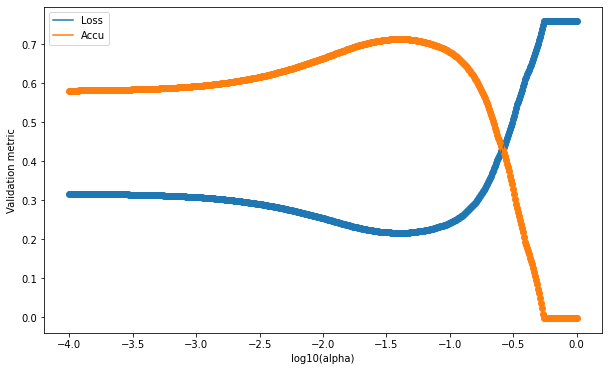

In [136]:
# Plot Loss vs point in grid search
data_lasso = pd.read_csv('grid_search_lasso_b.csv')

fig, axes = plt.subplots(figsize=(10,6))

axes.scatter(np.log10(data_lasso.alpha), data_lasso['valid_loss'])
axes.plot(np.log10(data_lasso.alpha), data_lasso['valid_loss'], label='Loss')

axes.scatter(np.log10(data_lasso.alpha), data_lasso['valid_accu'])
axes.plot(np.log10(data_lasso.alpha), data_lasso['valid_accu'], label='Accu')

axes.set_xlabel("log10(alpha)")
axes.set_ylabel("Validation metric")
axes.legend()
plt.show()

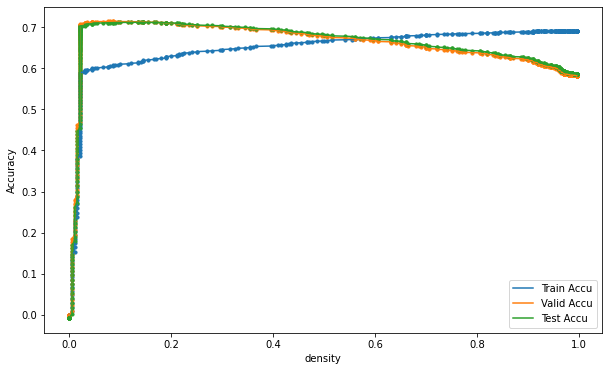

In [137]:
# Plot Acc vs sparsity
data_lasso = pd.read_csv('grid_search_lasso_b.csv')

fig, axes = plt.subplots(figsize=(10,6))

axes.scatter(data_lasso['sparcity'], data_lasso['train_accu'], s=10)
axes.plot(data_lasso['sparcity'], data_lasso['train_accu'], label='Train Accu')

axes.scatter(data_lasso['sparcity'], data_lasso['valid_accu'], s=10)
axes.plot(data_lasso['sparcity'], data_lasso['valid_accu'], label='Valid Accu')

axes.scatter(data_lasso['sparcity'], data_lasso['test_accu'], s=10)
axes.plot(data_lasso['sparcity'], data_lasso['test_accu'], label='Test Accu')

axes.set_xlabel("density")
axes.set_ylabel("Accuracy")
axes.legend()
plt.show()

In [138]:
# Display grid search results
data_lasso = pd.read_csv('grid_search_lasso_b.csv')

idx = data_lasso.valid_loss.idxmin()
best_alpha = data_lasso.loc[idx, 'alpha']

print("Parameters at Valid. Min.:\n")
print(data_lasso.iloc[idx, :])


Parameters at Valid. Min.:

iteration     328.000000
alpha           0.041806
sparcity        0.080000
valid_loss      0.216944
train_loss      0.395240
test_loss       0.222172
valid_accu      0.713646
train_accu      0.604760
test_accu       0.710599
Name: 327, dtype: float64


In [139]:
# Train with best hyperparameters
params['alpha'] = best_alpha
log_reg = Lasso(**params).fit(xtrain, ytrain.numpy().ravel())
joblib.dump(log_reg, 'model_lasso_valid_min_b.pkl')

['model_lasso_valid_min_b.pkl']

In [140]:
# Find MSE, R2, Accuracy, etc...
model = joblib.load('model_lasso_valid_min_b.pkl')

df_results = pd.DataFrame(index=['train', 'valid', 'test'], 
                          columns=['accuracy', 'loss'])

ypred = model.predict(xtrain.numpy())
df_results.loc['train', 'accuracy'] = r2_score(ytrain.numpy(), ypred)
df_results.loc['train', 'loss'] = mean_squared_error(ytrain.numpy(), ypred, squared=True)

ypred = model.predict(xvalid.numpy())
df_results.loc['valid', 'accuracy'] = r2_score(yvalid, ypred)
df_results.loc['valid', 'loss'] = mean_squared_error(yvalid.numpy(), ypred, squared=True)

ypred = model.predict(xtest.numpy())
df_results.loc['test', 'accuracy'] = r2_score(ytest.numpy(), ypred)
df_results.loc['test', 'loss'] = mean_squared_error(ytest.numpy(), ypred, squared=True)

# Save data
df_results.to_csv('accuracy_lasso_valid_min_b.csv', index=True)
df_results.head()

,accuracy,loss
train,0.60476,0.39524
valid,0.713646,0.216945
test,0.710599,0.222172


## Forward ResNet

In [61]:
# Load best forward model
n_features = len(cols_X)
n_layers = [11, 1]
model = MyNetRes(n_features, n_layers)
model.eval()

MyNetRes(
  (relu): ReLU(inplace=True)
  (fc1): Linear(in_features=200, out_features=11, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)

Epochs:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True
Last iteration = 653
Best validation at iteration = 164


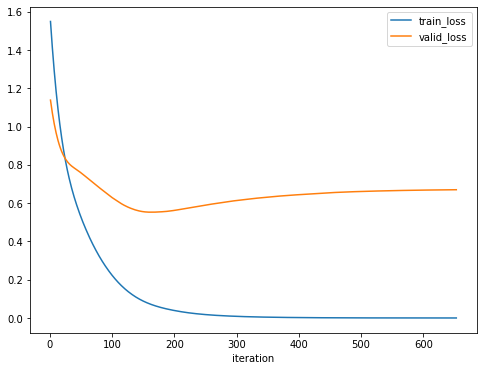

In [41]:
# TRAIN FORWARD
lockdown_unconstraint = ld.Lockout(model, lr=1e-3, loss_type=1, optim_id=2)

lockdown_unconstraint.train(dl_train, dl_valid, epochs=10000, early_stop=20, tol_loss=1e-6,
                            train_how="unconstraint", reset_weights=True)

lockdown_unconstraint.path_data.plot(x="iteration", 
                                     y=['train_loss', 'valid_loss'], 
                                     figsize=(8,6))
plt.show()

In [42]:
# Save model, data
tp.save_model(lockdown_unconstraint.model_best_valid, 'model_forward_valid_min_b_resnet.pth')
tp.save_model(lockdown_unconstraint.model_last, 'model_forward_last_b_resnet.pth')
lockdown_unconstraint.path_data.to_csv('data_forward_b_resnet.csv')

In [43]:
# Accuracy
mm = MyNetRes(n_features, n_layers)
mm.load_state_dict(torch.load('./model_forward_valid_min_b_resnet.pth'))
mm.eval()

xtrain = xtrain.to(device)
ypred = mm(xtrain)
r2 = r2_score(ytrain.detach().numpy(), ypred.detach().numpy())
print("Train R2 = {:.4f}".format(r2))

xvalid = xvalid.to(device)
ypred = mm(xvalid)
r2 = r2_score(yvalid.detach().numpy(), ypred.detach().numpy())
print("Valid R2 = {:.4f}".format(r2))

xtest = xtest.to(device)
ypred = mm(xtest)
r2 = r2_score(ytest.detach().numpy(), ypred.detach().numpy())
print("Test R2  = {:.4f}".format(r2))

Train R2 = 0.9307
Valid R2 = 0.2704
Test R2  = 0.2568


## Forward

In [56]:
# Load best forward model
n_features = len(cols_X)
n_layers = [10, 1]
model = MyNet(n_features, n_layers)
model.eval()

MyNet(
  (classifier): Sequential(
    (0): Linear(in_features=200, out_features=10, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)

Epochs:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True
Last iteration = 731
Best validation at iteration = 172


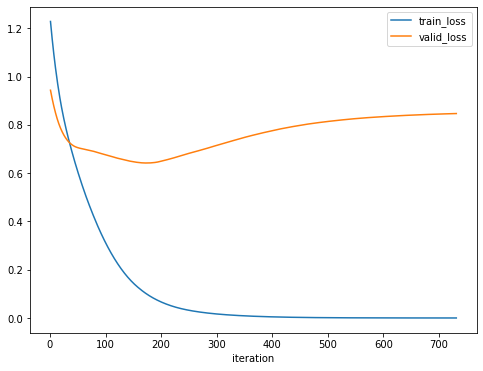

In [24]:
# TRAIN FORWARD
lockdown_unconstraint = ld.Lockout(model, lr=1e-3, loss_type=1, optim_id=2)

lockdown_unconstraint.train(dl_train, dl_valid, epochs=10000, early_stop=20, tol_loss=1e-6,
                            train_how="unconstraint", reset_weights=True)

lockdown_unconstraint.path_data.plot(x="iteration", 
                                     y=['train_loss', 'valid_loss'], 
                                     figsize=(8,6))
plt.show()

In [25]:
# Save model, data
tp.save_model(lockdown_unconstraint.model_best_valid, 'model_forward_valid_min_b.pth')
tp.save_model(lockdown_unconstraint.model_last, 'model_forward_last_b.pth')
lockdown_unconstraint.path_data.to_csv('data_forward_b.csv')

In [26]:
# Accuracy
mm = MyNet(n_features, n_layers)
mm.load_state_dict(torch.load('./model_forward_valid_min_b.pth'))
mm.eval()

xtrain = xtrain.to(device)
ypred = mm(xtrain)
r2 = r2_score(ytrain.detach().numpy(), ypred.detach().numpy())
print("Train R2 = {:.4f}".format(r2))

xvalid = xvalid.to(device)
ypred = mm(xvalid)
r2 = r2_score(yvalid.detach().numpy(), ypred.detach().numpy())
print("Valid R2 = {:.4f}".format(r2))

xtest = xtest.to(device)
ypred = mm(xtest)
r2 = r2_score(ytest.detach().numpy(), ypred.detach().numpy())
print("Test R2  = {:.4f}".format(r2))

Train R2 = 0.8972
Valid R2 = 0.1523
Test R2  = 0.1318


## LassoNet

In [154]:
!python '/Users/arbelogonzalezw/Documents/ML_WORK/LassoNet/lassonet/examples/miceprotein.py'

MEAN of 'ytrain' before adding noise = 7.253311634063721
STD of 'ytrain' before adding noise = 3.6737632751464844

Gaussian noise added to 'ytrain with:
- mean = 0.0
- std = 1.8368816375732422
Initialized dense model in 771 epochs, val loss 1.10e+01, regularization 7.36e+00
Lambda = 1.10e+01, selected 200 features in 100 epochs
val_loss (excl regularization) 1.10e+01, regularization 2.09e+00
Lambda = 1.12e+01, selected 200 features in 85 epochs
val_loss (excl regularization) 1.09e+01, regularization 1.79e+00
Lambda = 1.14e+01, selected 200 features in 10 epochs
val_loss (excl regularization) 1.09e+01, regularization 1.77e+00
Lambda = 1.17e+01, selected 200 features in 10 epochs
val_loss (excl regularization) 1.09e+01, regularization 1.74e+00
Lambda = 1.19e+01, selected 200 features in 10 epochs
val_loss (excl regularization) 1.09e+01, regularization 1.72e+00
Lambda = 1.21e+01, selected 200 features in 10 epochs
val_loss (excl regularization) 1.09e+01, regularization 1.69e+00
Lambda = 1

Lambda = 4.14e+01, selected 200 features in 50 epochs
val_loss (excl regularization) 1.05e+01, regularization 5.36e-01
Lambda = 4.22e+01, selected 200 features in 80 epochs
val_loss (excl regularization) 1.04e+01, regularization 4.76e-01
Lambda = 4.31e+01, selected 200 features in 40 epochs
val_loss (excl regularization) 1.04e+01, regularization 4.48e-01
Lambda = 4.39e+01, selected 199 features in 50 epochs
val_loss (excl regularization) 1.04e+01, regularization 4.14e-01
Lambda = 4.48e+01, selected 196 features in 30 epochs
val_loss (excl regularization) 1.03e+01, regularization 3.95e-01
Lambda = 4.57e+01, selected 195 features in 30 epochs
val_loss (excl regularization) 1.03e+01, regularization 3.77e-01
Lambda = 4.66e+01, selected 190 features in 20 epochs
val_loss (excl regularization) 1.03e+01, regularization 3.65e-01
Lambda = 4.76e+01, selected 187 features in 20 epochs
val_loss (excl regularization) 1.03e+01, regularization 3.54e-01
Lambda = 4.85e+01, selected 182 features in 20 e

Lambda = 1.66e+02, selected 73 features in 10 epochs
val_loss (excl regularization) 9.77e+00, regularization 8.83e-02
Lambda = 1.69e+02, selected 71 features in 10 epochs
val_loss (excl regularization) 9.76e+00, regularization 8.70e-02
Lambda = 1.72e+02, selected 70 features in 10 epochs
val_loss (excl regularization) 9.76e+00, regularization 8.56e-02
Lambda = 1.76e+02, selected 69 features in 20 epochs
val_loss (excl regularization) 9.75e+00, regularization 8.31e-02
Lambda = 1.79e+02, selected 69 features in 10 epochs
val_loss (excl regularization) 9.74e+00, regularization 8.19e-02
Lambda = 1.83e+02, selected 68 features in 10 epochs
val_loss (excl regularization) 9.74e+00, regularization 8.06e-02
Lambda = 1.86e+02, selected 67 features in 10 epochs
val_loss (excl regularization) 9.73e+00, regularization 7.93e-02
Lambda = 1.90e+02, selected 64 features in 20 epochs
val_loss (excl regularization) 9.73e+00, regularization 7.69e-02
Lambda = 1.94e+02, selected 64 features in 10 epochs
val

Lambda = 6.75e+02, selected 7 features in 10 epochs
val_loss (excl regularization) 9.62e+00, regularization 2.62e-02
Lambda = 6.89e+02, selected 6 features in 10 epochs
val_loss (excl regularization) 9.62e+00, regularization 2.59e-02
Lambda = 7.03e+02, selected 5 features in 10 epochs
val_loss (excl regularization) 9.61e+00, regularization 2.56e-02
Lambda = 7.17e+02, selected 5 features in 10 epochs
val_loss (excl regularization) 9.61e+00, regularization 2.54e-02
Lambda = 7.31e+02, selected 5 features in 10 epochs
val_loss (excl regularization) 9.61e+00, regularization 2.52e-02
Lambda = 7.46e+02, selected 5 features in 10 epochs
val_loss (excl regularization) 9.61e+00, regularization 2.49e-02
Lambda = 7.61e+02, selected 5 features in 10 epochs
val_loss (excl regularization) 9.61e+00, regularization 2.47e-02
Lambda = 7.76e+02, selected 5 features in 10 epochs
val_loss (excl regularization) 9.61e+00, regularization 2.44e-02
Lambda = 7.91e+02, selected 5 features in 10 epochs
val_loss (ex

Lambda = 2.81e+03, selected 2 features in 10 epochs
val_loss (excl regularization) 1.05e+01, regularization 1.22e-02
Lambda = 2.87e+03, selected 2 features in 20 epochs
val_loss (excl regularization) 1.05e+01, regularization 1.19e-02
Lambda = 2.92e+03, selected 2 features in 10 epochs
val_loss (excl regularization) 1.06e+01, regularization 1.18e-02
Lambda = 2.98e+03, selected 2 features in 10 epochs
val_loss (excl regularization) 1.06e+01, regularization 1.17e-02
Lambda = 3.04e+03, selected 2 features in 20 epochs
val_loss (excl regularization) 1.06e+01, regularization 1.14e-02
Lambda = 3.10e+03, selected 2 features in 10 epochs
val_loss (excl regularization) 1.07e+01, regularization 1.13e-02
Lambda = 3.17e+03, selected 2 features in 10 epochs
val_loss (excl regularization) 1.07e+01, regularization 1.11e-02
Lambda = 3.23e+03, selected 2 features in 20 epochs
val_loss (excl regularization) 1.07e+01, regularization 1.09e-02
Lambda = 3.29e+03, selected 2 features in 10 epochs
val_loss (ex

Lambda = 1.15e+04, selected 0 features in 19 epochs
val_loss (excl regularization) 1.78e+01, regularization 0.00e+00


## Lockout ResNet

In [45]:
# TRAIN WITH LOCKOUT
model = MyNetRes(n_features, n_layers)
model.load_state_dict(torch.load('./model_forward_last_b_resnet.pth'))
model.eval()

regul_type = [('fc1.weight', 1)]
regul_path = [('fc1.weight', True)]

t0_grid = {'fc1.weight': torch.from_numpy(np.geomspace(122.119652, 1e-2, num=100, endpoint=False))}
t0      = {'fc1.weight': torch.tensor(24.869976)}

lockdown_reg = ld.Lockout(model, lr=1e-2, 
                          regul_type=regul_type,
                          regul_path=regul_path, 
                          loss_type=1, tol_grads=1e-3)

In [46]:
lockdown_reg.train(dl_train, dl_valid, dl_test, epochs=100000, early_stop=20, tol_loss=1e-4,
                   train_how="decrease_t0")

Epochs1:   0%|          | 0/100000 [00:00<?, ?it/s]

Path 1: Early stopping = True
        Last iteration = 20


Epochs2:   0%|          | 0/100000 [00:00<?, ?it/s]

Best validation at iteration = 99259


In [47]:
# Save model, data
tp.save_model(lockdown_reg.model_best_valid, 'model_lockdown_valid_min_b_resnet.pth')
tp.save_model(lockdown_reg.model_last, 'model_lockdown_last_b_resnet.pth')
lockdown_reg.path_data.to_csv('data_lockdown_b_resnet.csv')

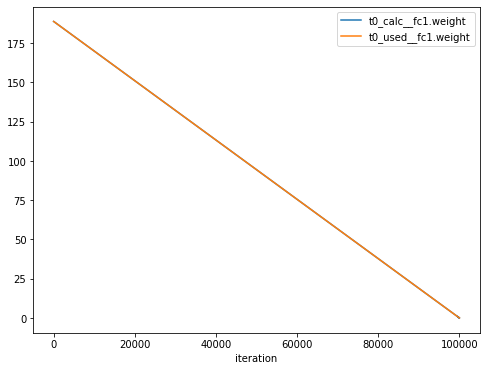

In [48]:
# Relevant plots
df = pd.read_csv('data_lockdown_b_resnet.csv')
df.plot(x="iteration", y=['t0_calc__fc1.weight', 't0_used__fc1.weight'], 
        figsize=(8,6))
plt.show()

In [49]:
# Accuracy
mm = MyNetRes(n_features, n_layers)
mm.load_state_dict(torch.load('./model_lockdown_valid_min_b_resnet.pth'))
mm.eval()

xtrain = xtrain.to(device)
ypred = mm(xtrain)
r2 = r2_score(ytrain.detach().numpy(), ypred.detach().numpy())
print("Train R2 = {:.4f}".format(r2))

xvalid = xvalid.to(device)
ypred = mm(xvalid)
r2 = r2_score(yvalid.detach().numpy(), ypred.detach().numpy())
print("Valid R2 = {:.4f}".format(r2))

xtest = xtest.to(device)
ypred = mm(xtest)
r2 = r2_score(ytest.detach().numpy(), ypred.detach().numpy())
print("Test R2  = {:.4f}".format(r2))

Train R2 = 0.7557
Valid R2 = 0.8661
Test R2  = 0.8648


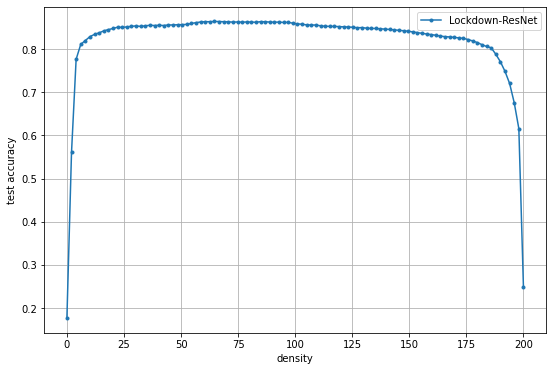

In [50]:
# Accuracy vs Sparcity
data_lockdown = pd.read_csv('data_lockdown_b_resnet.csv', index_col=0)
data_tmp_res = pd.DataFrame(columns=['sparcity', 'train_accu', 'valid_accu', 'test_accu', 't0_used'])
xgrid, step = np.linspace(0., 1., num=100,endpoint=True, retstep=True)
for x in xgrid:
    msk = (data_lockdown['sparcity__fc1.weight'] >= x) &    \
          (data_lockdown['sparcity__fc1.weight'] < x+step)
    train_accu = data_lockdown.loc[msk, 'train_accu'].mean()
    valid_accu = data_lockdown.loc[msk, 'valid_accu'].mean()
    test_accu  = data_lockdown.loc[msk, 'test_accu'].mean()
    t0_used = data_lockdown.loc[msk, 't0_used__fc1.weight'].mean()
    data_tmp_res = data_tmp_res.append({'sparcity': x, 
                                'train_accu': train_accu, 
                                'valid_accu': valid_accu, 
                                'test_accu': test_accu, 
                                't0_used': t0_used}, ignore_index=True)
data_tmp_res.dropna(axis='index', how='any', inplace=True)

fig, axes = plt.subplots(figsize=(9,6))

axes.plot(200*data_tmp_res['sparcity'], data_tmp_res['test_accu'], ".-", label='Lockdown-ResNet')

axes.grid(True)
axes.set_xlabel("density")
axes.set_ylabel("test accuracy")
axes.legend()

plt.show()

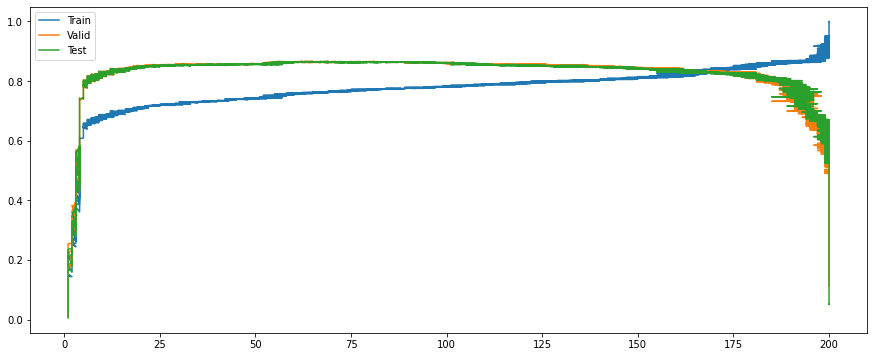

In [51]:
# 1000, 200, std=0.5
data_lockdown = pd.read_csv('data_lockdown_b_resnet.csv', index_col=0)

fig, axes = plt.subplots(figsize=(15,6))

axes.plot(200*data_lockdown['sparcity__fc1.weight'], 
          data_lockdown['train_accu'], label='Train')
axes.plot(200*data_lockdown['sparcity__fc1.weight'], 
          data_lockdown['valid_accu'], label='Valid')
axes.plot(200*data_lockdown['sparcity__fc1.weight'], 
          data_lockdown['test_accu'], label='Test')

axes.legend()
plt.show()

* ## Lockout

In [29]:
# TRAIN WITH LOCKOUT
model = MyNet(n_features, n_layers)
model.load_state_dict(torch.load('./model_forward_last_b.pth'))
model.eval()

regul_type = [('classifier.0.weight', 1)]
regul_path = [('classifier.0.weight', True)]

t0_grid = {'classifier.0.weight': torch.from_numpy(np.geomspace(74.083328, 1e-2, num=100, endpoint=False))}
t0      = {'classifier.0.weight': torch.tensor(24.869976)}

lockdown_reg = ld.Lockout(model, lr=1e-2, 
                          regul_type=regul_type,
                          regul_path=regul_path, 
                          loss_type=1, tol_grads=1e-2)

In [30]:
lockdown_reg.train(dl_train, dl_valid, dl_test, epochs=100000, early_stop=20, tol_loss=1e-4,
                   train_how="decrease_t0")

Epochs1:   0%|          | 0/100000 [00:00<?, ?it/s]

Path 1: Early stopping = True
        Last iteration = 20


Epochs2:   0%|          | 0/100000 [00:00<?, ?it/s]

Best validation at iteration = 99197


In [31]:
# Save model, data
tp.save_model(lockdown_reg.model_best_valid, 'model_lockdown_valid_min_b.pth')
tp.save_model(lockdown_reg.model_last, 'model_lockdown_last_b.pth')
lockdown_reg.path_data.to_csv('data_lockdown_b.csv')

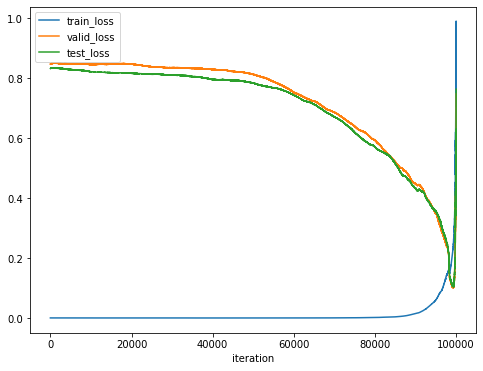

In [64]:
# Relevant plots
df = pd.read_csv('data_lockdown_b.csv')
df.plot(x="iteration", y=['train_loss', 'valid_loss', 'test_loss'], figsize=(8,6))
plt.show()

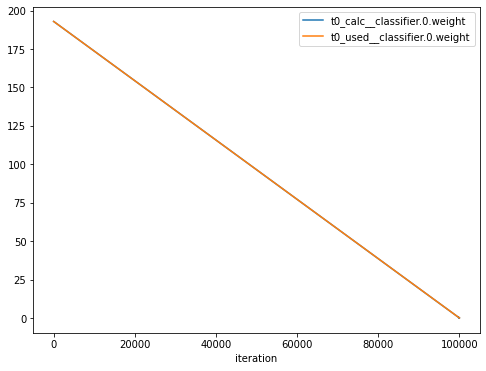

In [53]:
# Relevant plots
df = pd.read_csv('data_lockdown_b.csv')
df.plot(x="iteration", y=['t0_calc__classifier.0.weight', 't0_used__classifier.0.weight'], 
        figsize=(8,6))
plt.show()

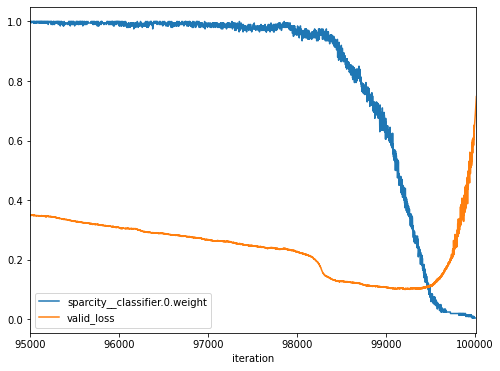

In [70]:
# Relevant plots
df = pd.read_csv('data_lockdown_b.csv')
df.plot(x="iteration", y=['sparcity__classifier.0.weight', 'valid_loss'], 
        figsize=(8,6))
plt.xlim(95000,100020)
plt.show()

In [57]:
# Accuracy
mm = MyNet(n_features, n_layers)
mm.load_state_dict(torch.load('./model_lockdown_valid_min_b.pth'))
mm.eval()

xtrain = xtrain.to(device)
ypred = mm(xtrain)
r2 = r2_score(ytrain.detach().numpy(), ypred.detach().numpy())
print("Train R2 = {:.4f}".format(r2))

xvalid = xvalid.to(device)
ypred = mm(xvalid)
r2 = r2_score(yvalid.detach().numpy(), ypred.detach().numpy())
print("Valid R2 = {:.4f}".format(r2))

xtest = xtest.to(device)
ypred = mm(xtest)
r2 = r2_score(ytest.detach().numpy(), ypred.detach().numpy())
print("Test R2  = {:.4f}".format(r2))

Train R2 = 0.7709
Valid R2 = 0.8678
Test R2  = 0.8635


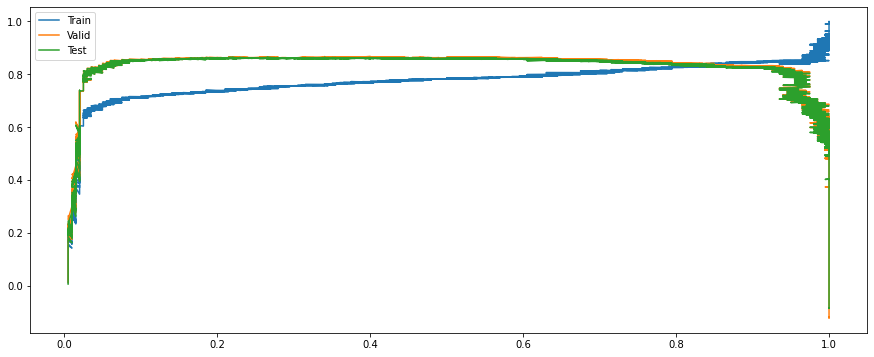

In [58]:
# 1000, 200, std=0.5
data_lockdown = pd.read_csv('data_lockdown_b.csv', index_col=0)
# data_lockdown = data_lockdown.sort_values(by=['iteration'], 
#                                           ascending=True)

fig, axes = plt.subplots(figsize=(15,6))

axes.plot(data_lockdown['sparcity__classifier.0.weight'], 
          data_lockdown['train_accu'], label='Train')
axes.plot(data_lockdown['sparcity__classifier.0.weight'], 
          data_lockdown['valid_accu'], label='Valid')
axes.plot(data_lockdown['sparcity__classifier.0.weight'], 
          data_lockdown['test_accu'], label='Test')

axes.legend()
plt.show()

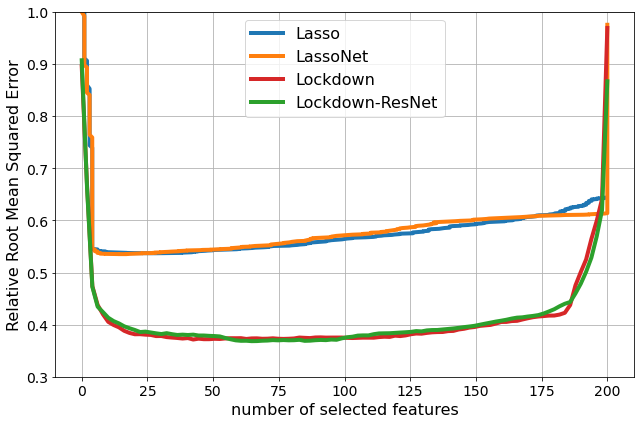

In [12]:
# Acc. v Sparcity (smooth)
data_lockdown     = pd.read_csv('data_lockdown_b.csv',        index_col=0)
data_lockdown_res = pd.read_csv('data_lockdown_b_resnet.csv', index_col=0)
data_lasso        = pd.read_csv('grid_search_lasso_b.csv')
data_lassonet     = pd.read_csv('lassonet_data_b.csv')

data_tmp     = pd.DataFrame(columns=['sparcity', 'test_accu', 't0_used'])
data_tmp_res = pd.DataFrame(columns=['sparcity', 'test_accu', 't0_used'])

xgrid, step = np.linspace(0., 1., num=100,endpoint=True, retstep=True)
for x in xgrid:
    msk = (data_lockdown['sparcity__classifier.0.weight'] >= x) &    \
          (data_lockdown['sparcity__classifier.0.weight'] < x+step)
    test_accu  = data_lockdown.loc[msk, 'test_accu'].mean()
    t0_used = data_lockdown.loc[msk, 't0_used__classifier.0.weight'].mean()
    data_tmp = data_tmp.append({'sparcity': x, 
                                'test_accu': test_accu, 
                                't0_used': t0_used}, ignore_index=True)

    msk = (data_lockdown_res['sparcity__fc1.weight'] >= x) &    \
          (data_lockdown_res['sparcity__fc1.weight'] < x+step)
    test_accu  = data_lockdown_res.loc[msk, 'test_accu'].mean()
    t0_used = data_lockdown_res.loc[msk, 't0_used__fc1.weight'].mean()
    data_tmp_res = data_tmp_res.append({'sparcity': x, 
                                'test_accu': test_accu, 
                                't0_used': t0_used}, ignore_index=True)

data_tmp.dropna(axis='index', how='any', inplace=True)
data_tmp_res.dropna(axis='index', how='any', inplace=True)

# Accuracy vs Sparcity
fig, axes = plt.subplots(figsize=(9,6))

axes.plot(200*data_lasso['sparcity'], np.sqrt(1.0 - data_lasso['test_accu']), 
          "-", label='Lasso', linewidth=4, markersize=10)
axes.plot(data_lassonet['features'], np.sqrt(1.0 -  data_lassonet['accuracy']), 
          "-", label='LassoNet', linewidth=4, markersize=10)
axes.plot(200*data_tmp['sparcity'], np.sqrt(1.0 -  data_tmp['test_accu']), 
          "-", label='Lockdown', linewidth=4, markersize=10, color="tab:red")
axes.plot(200*data_tmp_res['sparcity'], np.sqrt(1.0 -  data_tmp_res['test_accu']), 
          "-", label='Lockdown-ResNet', linewidth=4, markersize=10, color="tab:green")

axes.grid(True, zorder=2)
axes.set_xlabel("number of selected features", fontsize=16)
axes.set_ylabel("Relative Root Mean Squared Error", fontsize=16)
axes.legend(fontsize=16)
axes.tick_params(axis='both', which='major', labelsize=14)
axes.set_ylim(0.3, 1.0)

plt.tight_layout()
plt.savefig("outputs_b/error_vs_density_b.pdf", bbox_inches='tight')
plt.show()

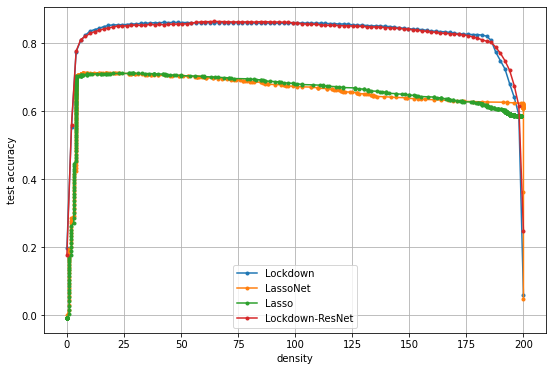

In [59]:
# Acc. v Sparcity (smooth)
data_lockdown = pd.read_csv('data_lockdown_b.csv', index_col=0)
data_tmp = pd.DataFrame(columns=['sparcity', 'train_accu', 'valid_accu', 'test_accu', 't0_used'])
xgrid, step = np.linspace(0., 1., num=100,endpoint=True, retstep=True)
for x in xgrid:
    msk = (data_lockdown['sparcity__classifier.0.weight'] >= x) &    \
          (data_lockdown['sparcity__classifier.0.weight'] < x+step)
    train_accu = data_lockdown.loc[msk, 'train_accu'].mean()
    valid_accu = data_lockdown.loc[msk, 'valid_accu'].mean()
    test_accu  = data_lockdown.loc[msk, 'test_accu'].mean()
    t0_used = data_lockdown.loc[msk, 't0_used__classifier.0.weight'].mean()
    data_tmp = data_tmp.append({'sparcity': x, 
                                'train_accu': train_accu, 
                                'valid_accu': valid_accu, 
                                'test_accu': test_accu, 
                                't0_used': t0_used}, ignore_index=True)
data_tmp.dropna(axis='index', how='any', inplace=True)

# Accuracy vs Sparcity
data_lasso = pd.read_csv('grid_search_lasso_b.csv')
data_lassonet = pd.read_csv('lassonet_data_b.csv')

fig, axes = plt.subplots(figsize=(9,6))

axes.plot(200*data_tmp['sparcity'], data_tmp['test_accu'], ".-", label='Lockdown')
axes.plot(data_lassonet['features'], data_lassonet['accuracy'], ".-", label='LassoNet')
axes.plot(200*data_lasso['sparcity'], data_lasso['test_accu'], ".-", label='Lasso')
axes.plot(200*data_tmp_res['sparcity'], data_tmp_res['test_accu'], ".-", label='Lockdown-ResNet')

axes.grid(True)
axes.set_xlabel("density")
axes.set_ylabel("test accuracy")
axes.legend()

plt.show()